only testing for windows right now

pip install --upgrade MDAnalysis

pip install --upgrade MDAnalysis[analysis]

pip install --upgrade MDAnalysisTests

conda install -c conda-forge nodejs

jupyter labextension install @jupyter-widgets/jupyterlab-manager

Version History: 
06/10/2022 - Vincent La - original script
07/22/2022 - Eugene Ragasa - modified script to be more efficient when reused
                 

adapted from https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsd.html

In [2]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# the next line is necessary to display plots in Jupyter
# %matplotlib inline

# ------------------------------------------------------------------------------------------------------------
# uncomment this section if battery_md is not in your PYTHONPATH
# import sys
# battery_md_path = "C:\\Users\\lavs2\\.vscode\\ADeLE\\battery_md\\src" 
# sys.path.append(battery_md_path)
# ------------------------------------------------------------------------------------------------------------

from battery_md.configuration import Configuration
from battery_md.jobs import Nvt
from battery_md.mixtures import ElectrolyteMixture
from battery_md.io.lammps.diffusion import calculate_diffusion_coefficient

In [3]:
project_path = "U:\\Projects\\2022_Adele\\005a_LiPF6_DEC_DMC_EC_EMC"
missing_files_path = os.path.join(project_path, "missing_files.txt")
electrolyte_mixtures = [
    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'DEC': 1.0, 'DMC': 1.0, 'EC': 1.0, 'EMC': 2.0}},
    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'DEC': 1.0, 'DMC': 1.0, 'EC': 1.0, 'EMC': 3.0}},
    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'DEC': 1.0, 'DMC': 1.0, 'EC': 1.0, 'EMC': 4.0}},
#    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'DEC': 1.0, 'DMC': 3.0, 'EC': 1.0, 'EMC': 1.0}},
#    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'DEC': 1.0, 'DMC': 2.0, 'EC': 1.0, 'EMC': 1.0}},
#    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'DEC': 1.0, 'DMC': 4.0, 'EC': 1.0, 'EMC': 1.0}},
#    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'DEC': 1.0, 'DMC': 2.0, 'EC': 1.0, 'EMC': 2.0}}
]

temperatures = [400, 300, 290, 280, 270, 260, 250, 240, 230]
atom_symbols = ['Li', 'P']
solvent_symbols = ['DEC', 'DMC', 'EC', 'EMC']


In [11]:
def check_if_project_path_exists(project_path):
    project_path_exists = os.path.isdir(project_path)
    print(f"project_path:{project_path}")
    print(f"project_path_exists:{project_path_exists}")
    return os.path.isdir(project_path_exists)

def get_mixture_name(mixture):
    mixture_ratios = [round(v) for v in mixture['solvent_composition_by_volume'].values()]
    str_mixture_ratios = ":".join([str(k) for k in mixture_ratios])
    mixture_name = '1_M_{}'.format(str_mixture_ratios)
    return mixture_name

class MissingFiles():
    def __init__(self, path):
        self.path = path
        self._initialize()
        
    def _initialize(self):
        if os.path.isfile(self.path):
            os.remove(self.path)
    
    def check_file(self, path):
        if not os.path.isfile(path):
            print(f"missing {path}")
            self.add_missing_file(path)
            return False
        else:
            return True
    
    def check_files(self, paths):
        return all([self.check_file(path) for path in paths])
    
    def add_missing_file(self, path):
        with open(self.path, 'w') as f:
            f.write(f"{path}\n")

In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
results=[]

o_missingfiles = MissingFiles(path=missing_files_path)

for idx_m, m in enumerate(electrolyte_mixtures):
    
    mixture_name = get_mixture_name(m)
    
    for idx_T, T in enumerate(temperatures):
        
        result = {}
        result["mixture_name"] = mixture_name
        result["temperature"] = T
        
        job_name = os.path.join(project_path, Nvt.get_simulation_name(m, T))
        trajectory_path = os.path.join(job_name, 'system.production.lammpstrj')
        #topology_path = os.path.join(job_name, 'system.start.data')
        topology_path = os.path.join(job_name, 'system.data')
        configuration_path = os.path.join(job_name, 'configuration.yaml')
        ionic_concentration = 1.0
        degrees_of_freedom = 3
        
        has_all_files = o_missingfiles.check_files(
            paths = [
                trajectory_path, 
                topology_path, 
                configuration_path
            ]
        )
        
        print(f"{job_name}:{has_all_files}")

        if has_all_files:
            
            #o_rmsd is a MDAnalaysis.analysis.rms.RMSD object
            results["o_rmsd"] = calculate_rmsd(trajectory_path,
                                               topology_path,
                                               configuration_path,
                                               atom_symbols=atom_symbols)
            
            for s in atom_symbols:

                # get time-series for time and rmsd arrays
                # cast into column arrays for
                time = np.array(results["o_rmsd"][s].results['rmsd'][:,0], copy=True).reshape(-1,1)
                rmsd = np.array(results["o_rmsd"][s].results['rmsd'][:,2], copy=True).reshape(-1,1)

                # calculate diffusion
                diffusion_coefficient = calculate_diffusion_coefficient(
                        time=time,
                        rmsd=rmsd,
                        degrees_of_freedom=3,
                        unitsconversion_time2seconds=1e-12,
                        unitsconversion_length2meters=1e-9
                )

                #calculate ionic conductivity
                ionic_conductivity =  calculate_ionic_conductivity(
                        diffusion_constant=diffusion_coefficient,
                        temperature=T,
                        ionic_concentration=ionic_concentration
                )

                result['{}.D'.format(s)] = diffusion_coefficient
                result['{}.kappa'.format(s)] = ionic_conductivity
                
                #configuration = Configuration()
                #configuration.read(configuration_path)
                #setting correct solvent_composition_by_volume b/c bug in configuration.yaml
                #configuration['mixture']['molar_definition']['solvent_composition_by_volume'] = m['solvent_composition_by_volume']
                
                # calculate solvent molar concentration
                #o = ElectrolyteMixture()                
                #o.configuration = configuration
                #o.run()

                #configuration = o.configuration
                #molar_concentration = configuration['mixture']['molar_concentration']

                #solvent_sum = 0.0
                #for solvent in solvent_symbols: 
                #    solvent_sum += molar_concentration[solvent]
                #for solvent in solvent_symbols: 
                #    result['c.{}'.format(solvent)] = molar_concentration[solvent] / solvent_sum

                #print(result)

        
            results.append(result)
            
        else:
            pass


missing U:\Projects\2022_Adele\005a_LiPF6_DEC_DMC_EC_EMC\1_M_LiPF6_1112_DEC_DMC_EC_EMC__nvt__400K\system.production.lammpstrj
missing U:\Projects\2022_Adele\005a_LiPF6_DEC_DMC_EC_EMC\1_M_LiPF6_1112_DEC_DMC_EC_EMC__nvt__400K\system.data
missing U:\Projects\2022_Adele\005a_LiPF6_DEC_DMC_EC_EMC\1_M_LiPF6_1112_DEC_DMC_EC_EMC__nvt__400K\configuration.yaml
U:\Projects\2022_Adele\005a_LiPF6_DEC_DMC_EC_EMC\1_M_LiPF6_1112_DEC_DMC_EC_EMC__nvt__400K:False
U:\Projects\2022_Adele\005a_LiPF6_DEC_DMC_EC_EMC\1_M_LiPF6_1112_DEC_DMC_EC_EMC__nvt__300K:True


NameError: name 'calculate_rmsd' is not defined

In [2]:
results

NameError: name 'results' is not defined

In [5]:
df_results = pd.DataFrame(results)
df_results

,mixture_name,temperature,Li.D,Li.kappa,P.D,P.kappa
0,1_M_1:1:1:2,300,4.272113e-08,0.159445,2.828141e-08,0.105552
1,1_M_1:1:1:2,290,4.532020e-08,0.174978,3.903642e-08,0.150716
2,1_M_1:1:1:2,280,2.892396e-08,0.115661,4.754014e-08,0.190104
3,1_M_1:1:1:2,270,2.623181e-08,0.108781,1.799854e-08,0.074638
4,1_M_1:1:1:2,260,2.369441e-08,0.102038,1.671087e-08,0.071964
5,1_M_1:1:1:2,250,1.710705e-08,0.076617,2.828893e-08,0.126697
6,1_M_1:1:1:2,240,1.565458e-08,0.073033,1.454937e-08,0.067877
7,1_M_1:1:1:2,230,1.154515e-08,0.056203,8.985352e-09,0.043742
8,1_M_1:1:1:3,300,5.851864e-08,0.218404,4.496825e-08,0.167831
9,1_M_1:1:1:3,290,3.649859e-08,0.140918,5.644950e-08,0.217947


In [6]:
# write results as .csv
results_path = '{}_{}.csv'.format('LiPF6', 'DEC_DMC_EC_EMC')
df_results.to_csv(os.path.join(project_path, results_path))

(230.0, 300.0)

Text(0, 0.5, 'ionic conductivity [S cm^2]')

Text(0.5, 0, 'temperature [K]')

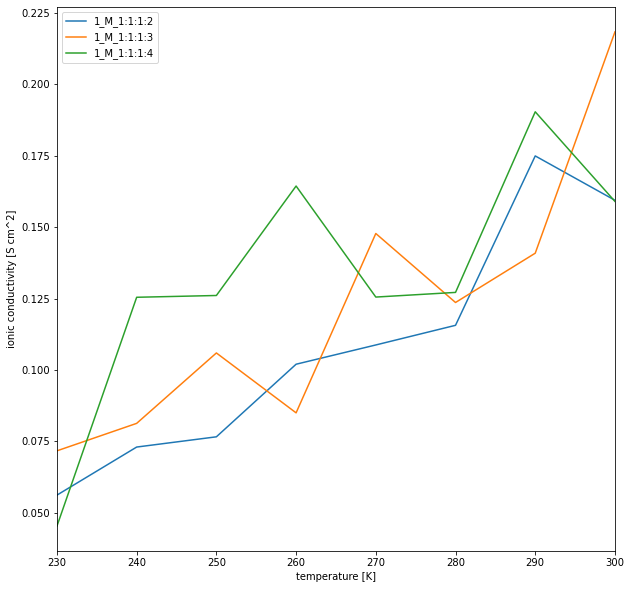

In [10]:
#plotting
from matplotlib import style
# style.use('dark_background')

plot_path = os.path.join(project_path, 'plots')
mixtures = df_results.mixture_name.unique() 

#separate plots by mixture
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)
for mixture in mixtures:
    df = df_results[ df_results['mixture_name'] == mixture]
    df = df[df['temperature'] != 400]
    ax.plot(df['temperature'], df['Li.kappa'], label=mixture)

ax.set_xlim( [ df['temperature'].min(), df['temperature'].max() ] )
ax.set_ylabel('ionic conductivity [S cm^2]')
ax.set_xlabel('temperature [K]')
ax.legend()



In [8]:
plt.show()
if False:
    for m in df_results.mixture_name.unique():

        df_filtered = df_results[df_results['mixture_name'] == m ]
        ax.plot(x = df)

        #excluding 400 degree value

        ax_diffusion = df_filtered[df_filtered['temperature'] != 400].plot(x = 'temperature', 
                                        y = ['Li.D', 'P.D'], 
                                        style = '.-', 
                                        title = m,
                                        figsize = (10,10)
                                        )
        ax_diffusion.set_ylabel('Diffusion Coefficient')
        plt.savefig(os.path.join(plot_path, '{}_diffusion_v_temp.png'.format(m.replace(':', ';'))))

        #excluding 400 degree value
        ax_conductivity = df_filtered[df_filtered['temperature'] != 400].plot(x = 'temperature', 
                                           y = ['Li.kappa', 'P.kappa'], 
                                           style = '.-', 
                                           title = m,
                                           figsize = (10,10)
                                           )
        ax_conductivity.set_ylabel('Conductivity')
        plt.savefig(os.path.join(plot_path, '{}_conductivity_v_temp.png'.format(m.replace(':', ';'))))

In [9]:
rmsd

array([[4.08978476e-07],
       [2.01135543e-01],
       [3.56904266e-01],
       ...,
       [1.08371201e+01],
       [1.21122986e+01],
       [1.21222587e+01]])